# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer1 = separable_conv2d_batchnorm(concat_layer, filters)
    output_layer2 = separable_conv2d_batchnorm(output_layer1, filters)
    
    return output_layer2

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_1 = encoder_block(inputs, 64, 2)
    encoder_2 = encoder_block(encoder_1, 128, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1x1 = conv2d_batchnorm(encoder_2, 256, kernel_size=1, strides=1)

    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1 = decoder_block(conv_1x1, encoder_1, 128)
    decoder_2 = decoder_block(decoder_1, inputs, 64)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_2)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.005
batch_size = 24
num_epochs = 100
steps_per_epoch = 150
validation_steps = 50
workers = 4

Epoch 1/100
149/150 [============================>.] - ETA: 0s - loss: 0.1844

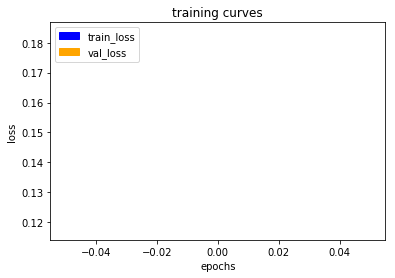

150/150 [==============================] - 98s - loss: 0.1835 - val_loss: 0.1174
Epoch 2/100
149/150 [============================>.] - ETA: 0s - loss: 0.0491

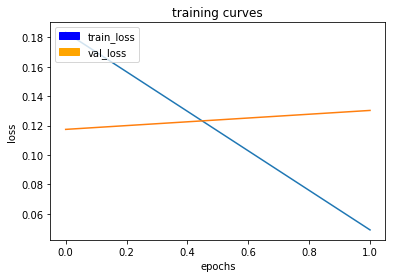

150/150 [==============================] - 96s - loss: 0.0491 - val_loss: 0.1303
Epoch 3/100
149/150 [============================>.] - ETA: 0s - loss: 0.0414

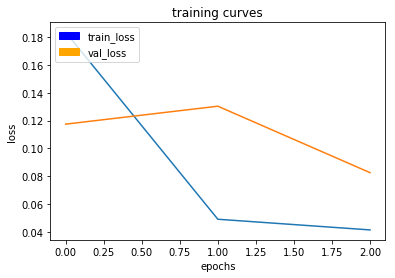

150/150 [==============================] - 96s - loss: 0.0415 - val_loss: 0.0825
Epoch 4/100
149/150 [============================>.] - ETA: 0s - loss: 0.0436

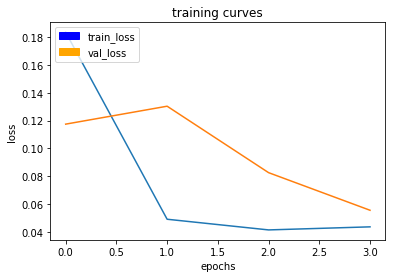

150/150 [==============================] - 96s - loss: 0.0435 - val_loss: 0.0555
Epoch 5/100
149/150 [============================>.] - ETA: 0s - loss: 0.0346

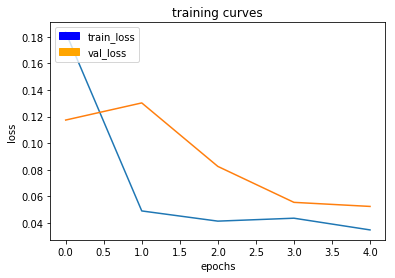

150/150 [==============================] - 96s - loss: 0.0347 - val_loss: 0.0524
Epoch 6/100
149/150 [============================>.] - ETA: 0s - loss: 0.0349

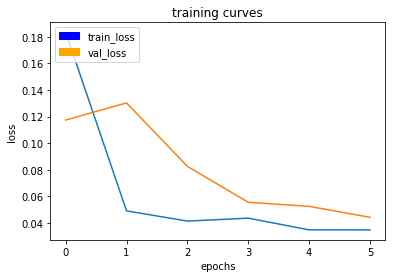

150/150 [==============================] - 96s - loss: 0.0349 - val_loss: 0.0442
Epoch 7/100
149/150 [============================>.] - ETA: 0s - loss: 0.0317

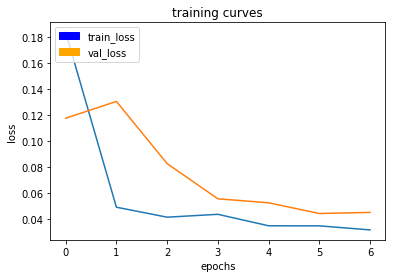

150/150 [==============================] - 96s - loss: 0.0316 - val_loss: 0.0450
Epoch 8/100
149/150 [============================>.] - ETA: 0s - loss: 0.0317

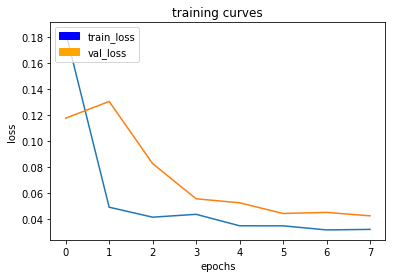

150/150 [==============================] - 96s - loss: 0.0320 - val_loss: 0.0424
Epoch 9/100
149/150 [============================>.] - ETA: 0s - loss: 0.0293

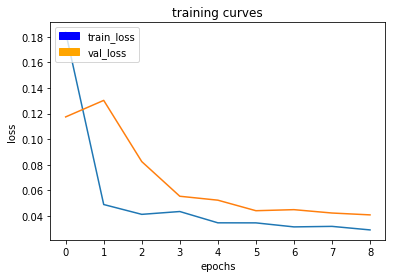

150/150 [==============================] - 97s - loss: 0.0292 - val_loss: 0.0410
Epoch 10/100
149/150 [============================>.] - ETA: 0s - loss: 0.0299

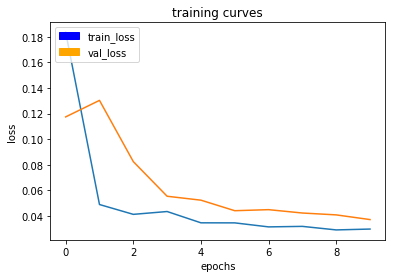

150/150 [==============================] - 96s - loss: 0.0299 - val_loss: 0.0373
Epoch 11/100
149/150 [============================>.] - ETA: 0s - loss: 0.0259

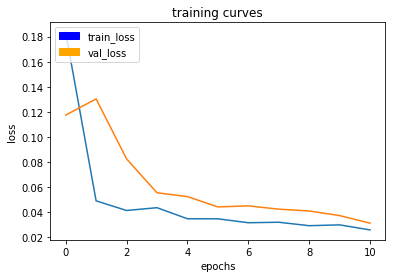

150/150 [==============================] - 97s - loss: 0.0259 - val_loss: 0.0312
Epoch 12/100
149/150 [============================>.] - ETA: 0s - loss: 0.0274

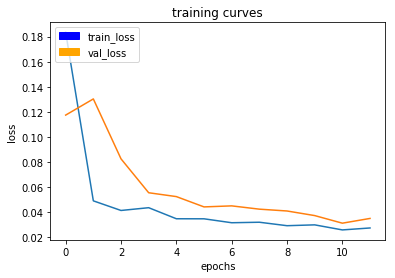

150/150 [==============================] - 97s - loss: 0.0274 - val_loss: 0.0350
Epoch 13/100
149/150 [============================>.] - ETA: 0s - loss: 0.0265

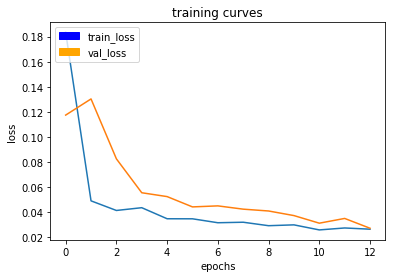

150/150 [==============================] - 97s - loss: 0.0265 - val_loss: 0.0272
Epoch 14/100
149/150 [============================>.] - ETA: 0s - loss: 0.0271

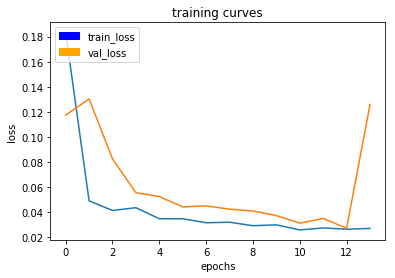

150/150 [==============================] - 97s - loss: 0.0271 - val_loss: 0.1259
Epoch 15/100
149/150 [============================>.] - ETA: 0s - loss: 0.0252

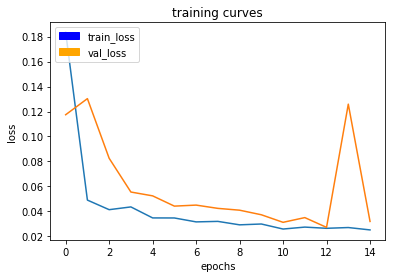

150/150 [==============================] - 97s - loss: 0.0251 - val_loss: 0.0319
Epoch 16/100
149/150 [============================>.] - ETA: 0s - loss: 0.0250

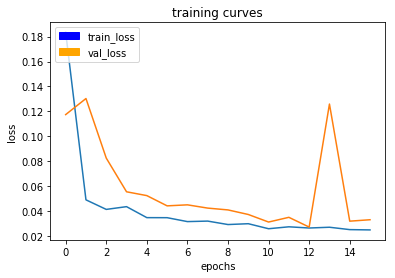

150/150 [==============================] - 98s - loss: 0.0249 - val_loss: 0.0331
Epoch 17/100
149/150 [============================>.] - ETA: 0s - loss: 0.0241

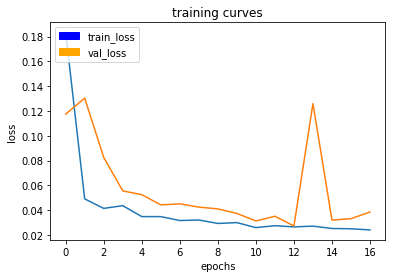

150/150 [==============================] - 98s - loss: 0.0241 - val_loss: 0.0384
Epoch 18/100
149/150 [============================>.] - ETA: 0s - loss: 0.0264

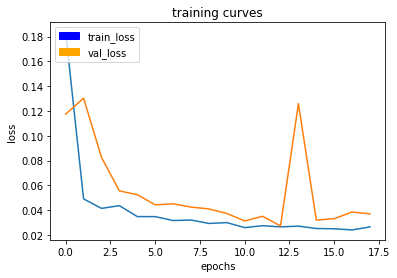

150/150 [==============================] - 97s - loss: 0.0264 - val_loss: 0.0370
Epoch 19/100
149/150 [============================>.] - ETA: 0s - loss: 0.0220

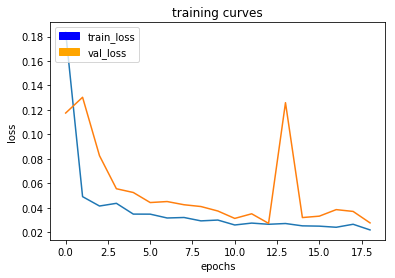

150/150 [==============================] - 97s - loss: 0.0219 - val_loss: 0.0276
Epoch 20/100
149/150 [============================>.] - ETA: 0s - loss: 0.0239

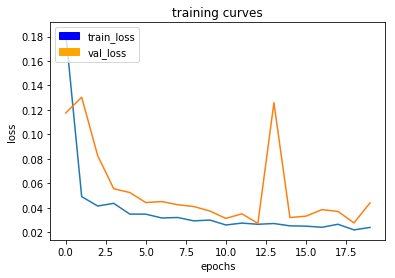

150/150 [==============================] - 97s - loss: 0.0239 - val_loss: 0.0439
Epoch 21/100
149/150 [============================>.] - ETA: 0s - loss: 0.0212

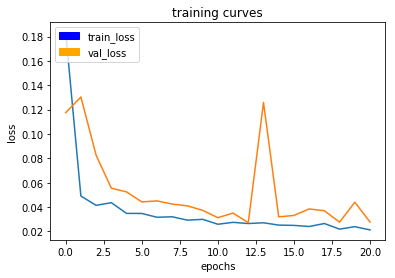

150/150 [==============================] - 97s - loss: 0.0212 - val_loss: 0.0276
Epoch 22/100
149/150 [============================>.] - ETA: 0s - loss: 0.0228

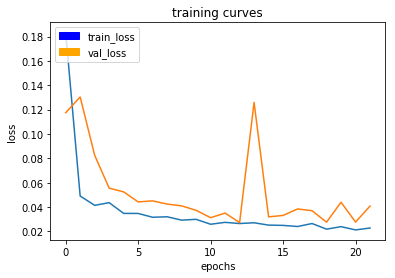

150/150 [==============================] - 97s - loss: 0.0228 - val_loss: 0.0408
Epoch 23/100
149/150 [============================>.] - ETA: 0s - loss: 0.0223

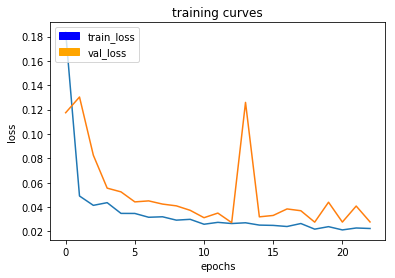

150/150 [==============================] - 98s - loss: 0.0224 - val_loss: 0.0278
Epoch 24/100
149/150 [============================>.] - ETA: 0s - loss: 0.0209

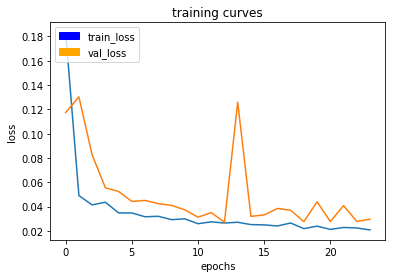

150/150 [==============================] - 97s - loss: 0.0208 - val_loss: 0.0296
Epoch 25/100
149/150 [============================>.] - ETA: 0s - loss: 0.0204

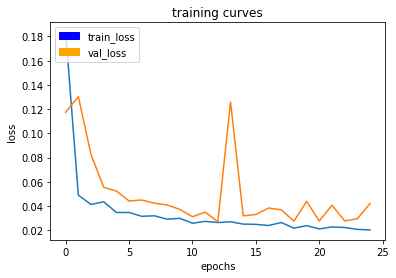

150/150 [==============================] - 97s - loss: 0.0204 - val_loss: 0.0422
Epoch 26/100
149/150 [============================>.] - ETA: 0s - loss: 0.0207

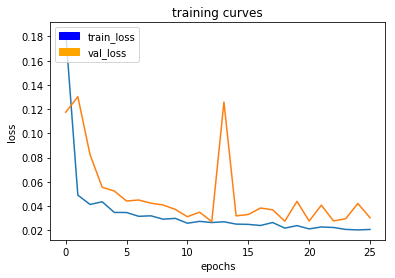

150/150 [==============================] - 97s - loss: 0.0207 - val_loss: 0.0304
Epoch 27/100
149/150 [============================>.] - ETA: 0s - loss: 0.0202

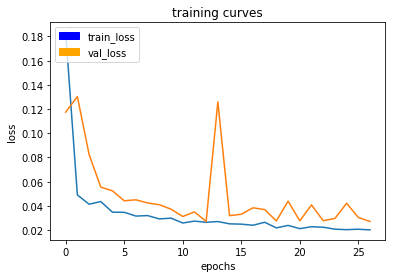

150/150 [==============================] - 97s - loss: 0.0201 - val_loss: 0.0271
Epoch 28/100
149/150 [============================>.] - ETA: 0s - loss: 0.0205

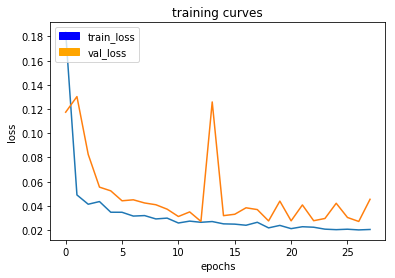

150/150 [==============================] - 97s - loss: 0.0205 - val_loss: 0.0455
Epoch 29/100
149/150 [============================>.] - ETA: 0s - loss: 0.0206

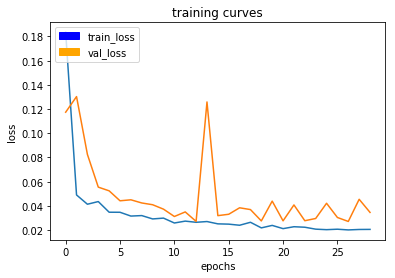

150/150 [==============================] - 97s - loss: 0.0205 - val_loss: 0.0346
Epoch 30/100
149/150 [============================>.] - ETA: 0s - loss: 0.0189

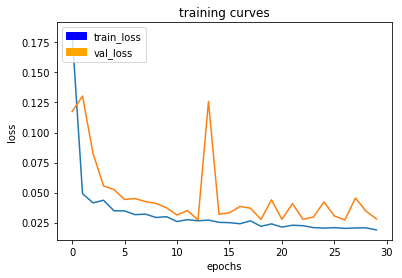

150/150 [==============================] - 97s - loss: 0.0188 - val_loss: 0.0280
Epoch 31/100
149/150 [============================>.] - ETA: 0s - loss: 0.0187

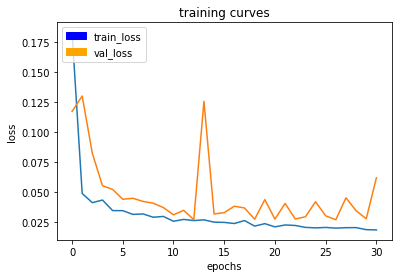

150/150 [==============================] - 97s - loss: 0.0187 - val_loss: 0.0621
Epoch 32/100
149/150 [============================>.] - ETA: 0s - loss: 0.0217

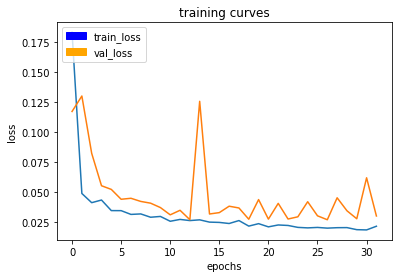

150/150 [==============================] - 97s - loss: 0.0217 - val_loss: 0.0303
Epoch 33/100
149/150 [============================>.] - ETA: 0s - loss: 0.0184

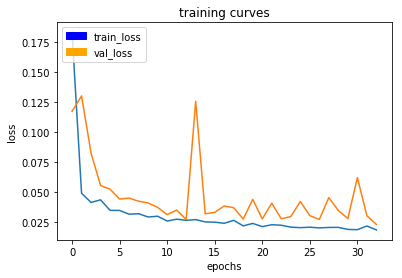

150/150 [==============================] - 96s - loss: 0.0184 - val_loss: 0.0231
Epoch 34/100
149/150 [============================>.] - ETA: 0s - loss: 0.0174

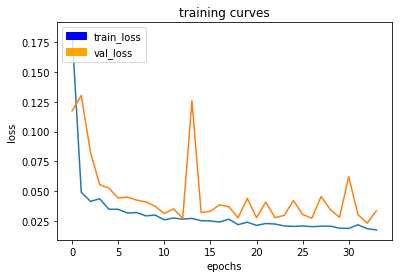

150/150 [==============================] - 97s - loss: 0.0173 - val_loss: 0.0336
Epoch 35/100
149/150 [============================>.] - ETA: 0s - loss: 0.0185

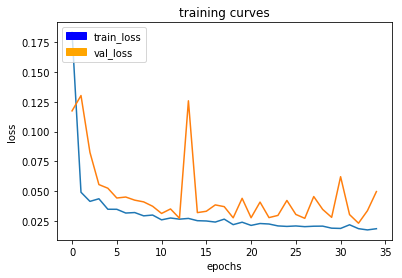

150/150 [==============================] - 98s - loss: 0.0184 - val_loss: 0.0496
Epoch 36/100
149/150 [============================>.] - ETA: 0s - loss: 0.0184

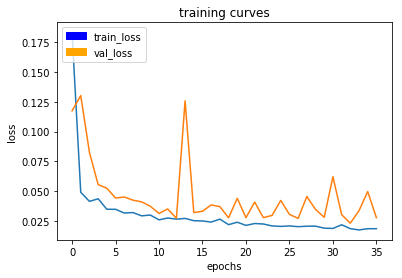

150/150 [==============================] - 97s - loss: 0.0184 - val_loss: 0.0277
Epoch 37/100
149/150 [============================>.] - ETA: 0s - loss: 0.0203

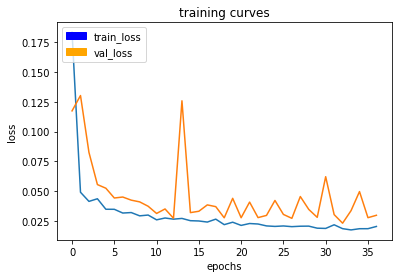

150/150 [==============================] - 97s - loss: 0.0203 - val_loss: 0.0297
Epoch 38/100
149/150 [============================>.] - ETA: 0s - loss: 0.0184

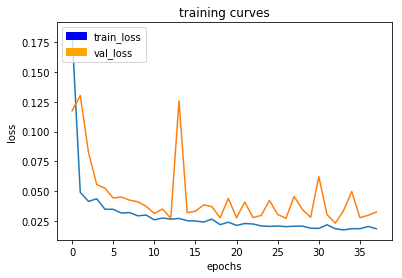

150/150 [==============================] - 97s - loss: 0.0183 - val_loss: 0.0325
Epoch 39/100
149/150 [============================>.] - ETA: 0s - loss: 0.0170

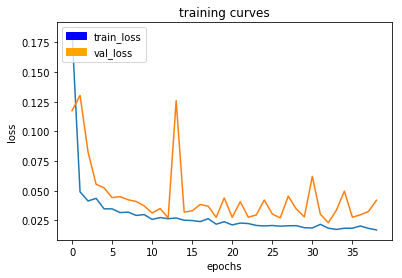

150/150 [==============================] - 97s - loss: 0.0170 - val_loss: 0.0420
Epoch 40/100
149/150 [============================>.] - ETA: 0s - loss: 0.0186

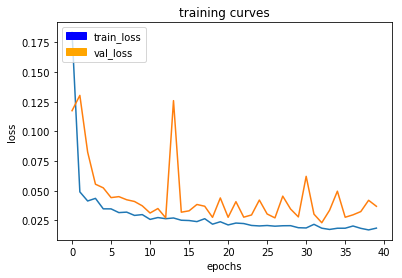

150/150 [==============================] - 97s - loss: 0.0185 - val_loss: 0.0369
Epoch 41/100
149/150 [============================>.] - ETA: 0s - loss: 0.0179

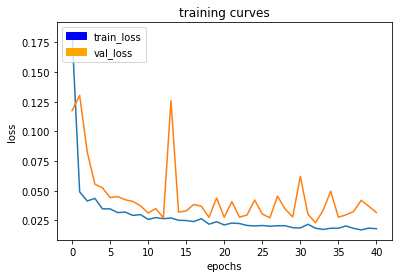

150/150 [==============================] - 97s - loss: 0.0180 - val_loss: 0.0317
Epoch 42/100
149/150 [============================>.] - ETA: 0s - loss: 0.0169

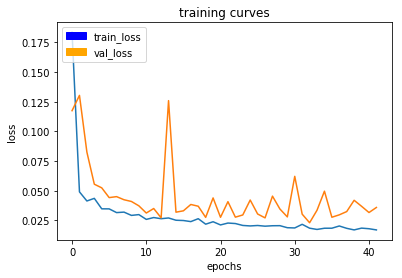

150/150 [==============================] - 97s - loss: 0.0170 - val_loss: 0.0359
Epoch 43/100
149/150 [============================>.] - ETA: 0s - loss: 0.0173

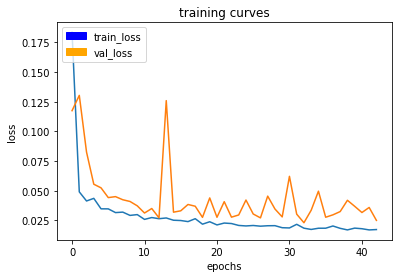

150/150 [==============================] - 96s - loss: 0.0173 - val_loss: 0.0250
Epoch 44/100
149/150 [============================>.] - ETA: 0s - loss: 0.0165

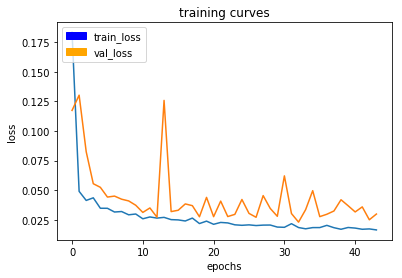

150/150 [==============================] - 97s - loss: 0.0165 - val_loss: 0.0299
Epoch 45/100
149/150 [============================>.] - ETA: 0s - loss: 0.0182

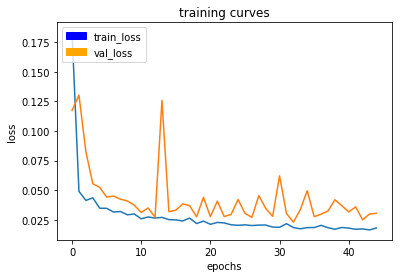

150/150 [==============================] - 97s - loss: 0.0181 - val_loss: 0.0305
Epoch 46/100
149/150 [============================>.] - ETA: 0s - loss: 0.0152

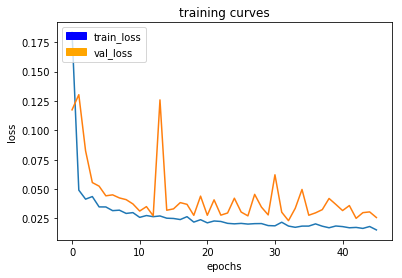

150/150 [==============================] - 97s - loss: 0.0152 - val_loss: 0.0257
Epoch 47/100
149/150 [============================>.] - ETA: 0s - loss: 0.0162

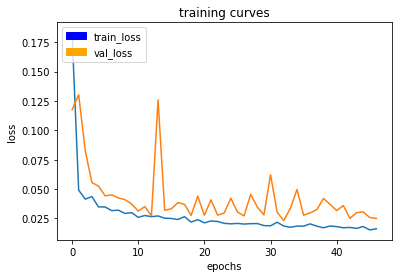

150/150 [==============================] - 97s - loss: 0.0162 - val_loss: 0.0250
Epoch 48/100
149/150 [============================>.] - ETA: 0s - loss: 0.0168

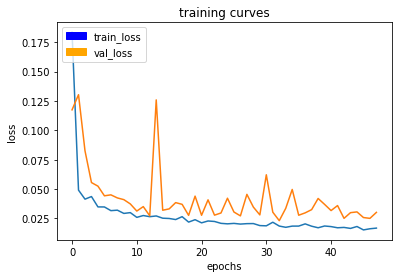

150/150 [==============================] - 97s - loss: 0.0168 - val_loss: 0.0301
Epoch 49/100
149/150 [============================>.] - ETA: 0s - loss: 0.0154

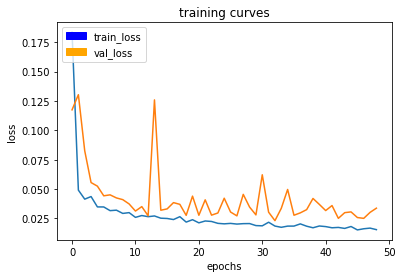

150/150 [==============================] - 97s - loss: 0.0154 - val_loss: 0.0337
Epoch 50/100
149/150 [============================>.] - ETA: 0s - loss: 0.0153

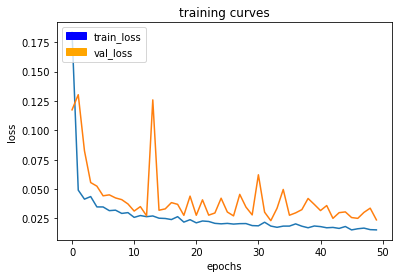

150/150 [==============================] - 97s - loss: 0.0153 - val_loss: 0.0237
Epoch 51/100
149/150 [============================>.] - ETA: 0s - loss: 0.0160

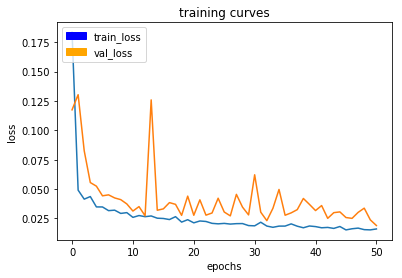

150/150 [==============================] - 97s - loss: 0.0160 - val_loss: 0.0189
Epoch 52/100
149/150 [============================>.] - ETA: 0s - loss: 0.0158

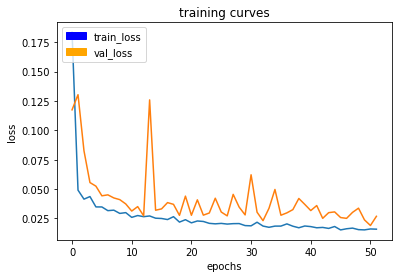

150/150 [==============================] - 97s - loss: 0.0158 - val_loss: 0.0268
Epoch 53/100
149/150 [============================>.] - ETA: 0s - loss: 0.0153

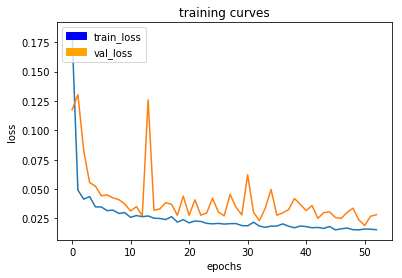

150/150 [==============================] - 97s - loss: 0.0153 - val_loss: 0.0282
Epoch 54/100
149/150 [============================>.] - ETA: 0s - loss: 0.0328

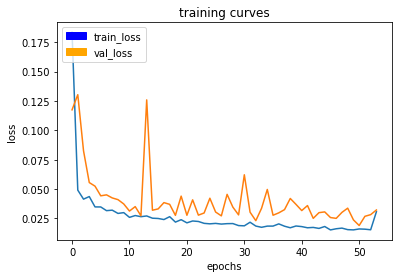

150/150 [==============================] - 97s - loss: 0.0327 - val_loss: 0.0322
Epoch 55/100
149/150 [============================>.] - ETA: 0s - loss: 0.0213

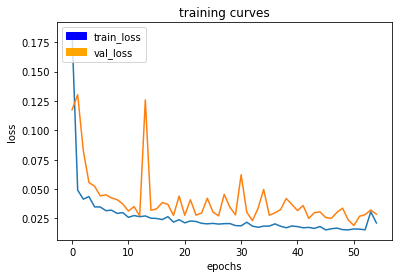

150/150 [==============================] - 97s - loss: 0.0213 - val_loss: 0.0286
Epoch 56/100
149/150 [============================>.] - ETA: 0s - loss: 0.0174

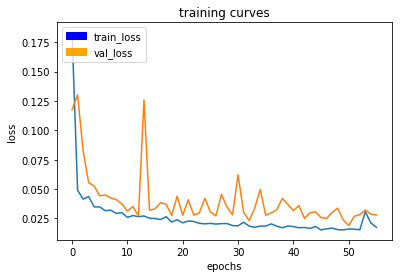

150/150 [==============================] - 97s - loss: 0.0174 - val_loss: 0.0279
Epoch 57/100
149/150 [============================>.] - ETA: 0s - loss: 0.0176

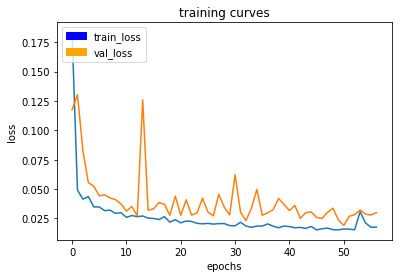

150/150 [==============================] - 97s - loss: 0.0176 - val_loss: 0.0299
Epoch 58/100
149/150 [============================>.] - ETA: 0s - loss: 0.0157

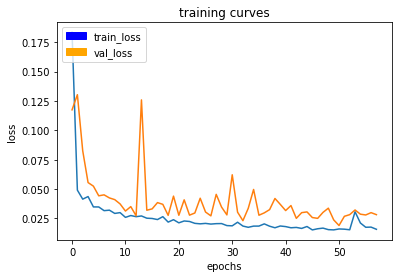

150/150 [==============================] - 97s - loss: 0.0157 - val_loss: 0.0282
Epoch 59/100
149/150 [============================>.] - ETA: 0s - loss: 0.0158

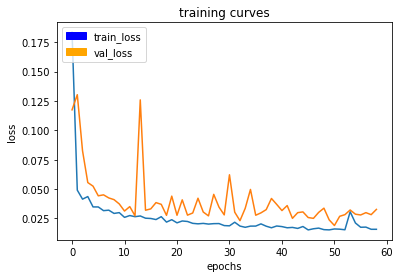

150/150 [==============================] - 97s - loss: 0.0158 - val_loss: 0.0326
Epoch 60/100
149/150 [============================>.] - ETA: 0s - loss: 0.0154

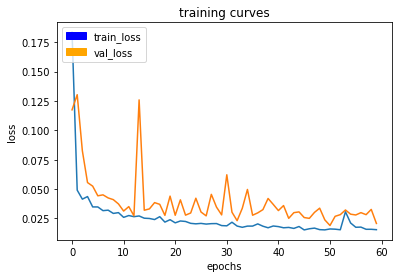

150/150 [==============================] - 97s - loss: 0.0154 - val_loss: 0.0207
Epoch 61/100
149/150 [============================>.] - ETA: 0s - loss: 0.0148

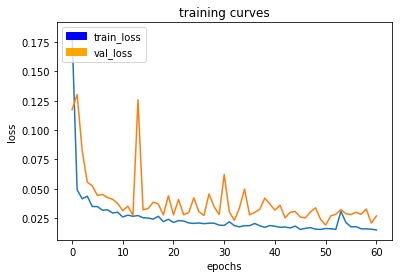

150/150 [==============================] - 97s - loss: 0.0148 - val_loss: 0.0267
Epoch 62/100
149/150 [============================>.] - ETA: 0s - loss: 0.0187

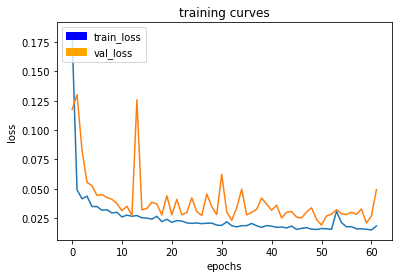

150/150 [==============================] - 97s - loss: 0.0187 - val_loss: 0.0492
Epoch 63/100
149/150 [============================>.] - ETA: 0s - loss: 0.0154

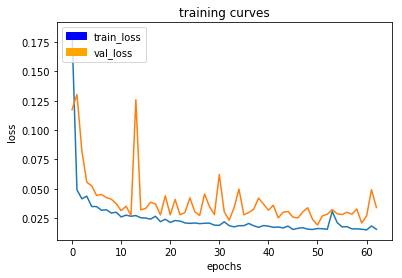

150/150 [==============================] - 97s - loss: 0.0154 - val_loss: 0.0339
Epoch 64/100
149/150 [============================>.] - ETA: 0s - loss: 0.0145

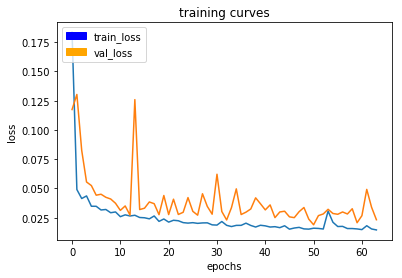

150/150 [==============================] - 97s - loss: 0.0145 - val_loss: 0.0233
Epoch 65/100
149/150 [============================>.] - ETA: 0s - loss: 0.0146

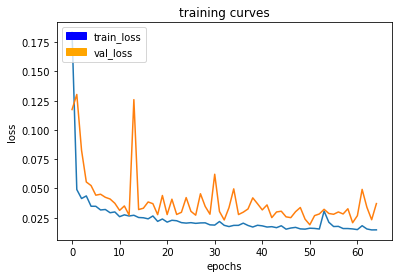

150/150 [==============================] - 97s - loss: 0.0146 - val_loss: 0.0370
Epoch 66/100
149/150 [============================>.] - ETA: 0s - loss: 0.0144

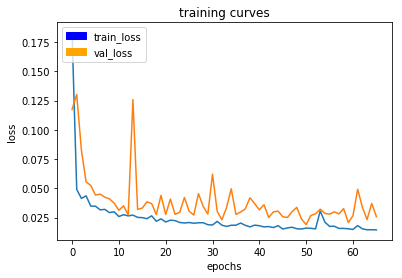

150/150 [==============================] - 97s - loss: 0.0144 - val_loss: 0.0257
Epoch 67/100
149/150 [============================>.] - ETA: 0s - loss: 0.0147

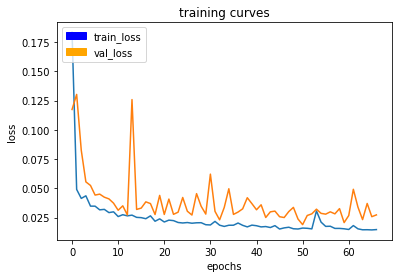

150/150 [==============================] - 98s - loss: 0.0146 - val_loss: 0.0273
Epoch 68/100
149/150 [============================>.] - ETA: 0s - loss: 0.0137

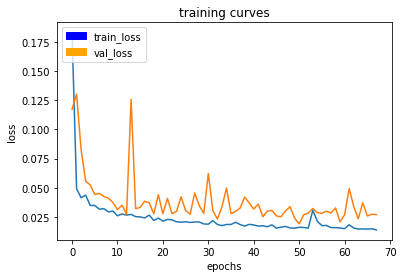

150/150 [==============================] - 98s - loss: 0.0137 - val_loss: 0.0269
Epoch 69/100
149/150 [============================>.] - ETA: 0s - loss: 0.0138

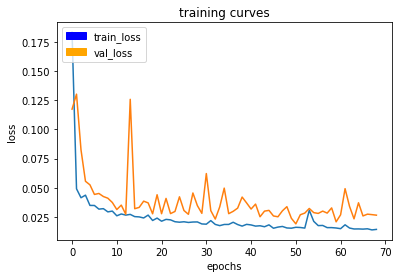

150/150 [==============================] - 97s - loss: 0.0142 - val_loss: 0.0264
Epoch 70/100
149/150 [============================>.] - ETA: 0s - loss: 0.0136

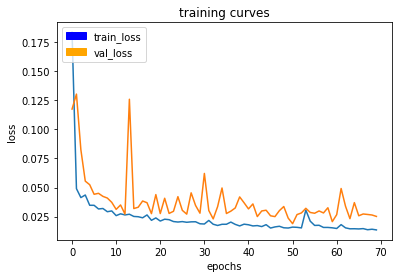

150/150 [==============================] - 97s - loss: 0.0136 - val_loss: 0.0252
Epoch 71/100
149/150 [============================>.] - ETA: 0s - loss: 0.0169

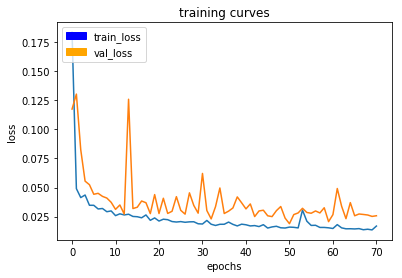

150/150 [==============================] - 97s - loss: 0.0169 - val_loss: 0.0258
Epoch 72/100
149/150 [============================>.] - ETA: 0s - loss: 0.0152

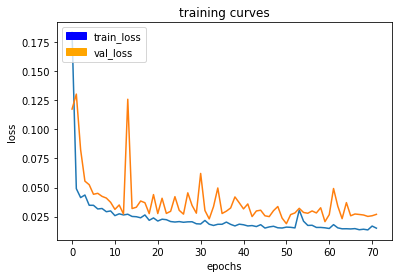

150/150 [==============================] - 97s - loss: 0.0152 - val_loss: 0.0270
Epoch 73/100
149/150 [============================>.] - ETA: 0s - loss: 0.0126

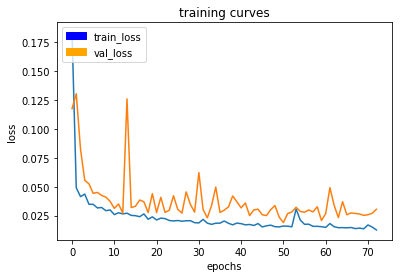

150/150 [==============================] - 97s - loss: 0.0126 - val_loss: 0.0304
Epoch 74/100
149/150 [============================>.] - ETA: 0s - loss: 0.0132

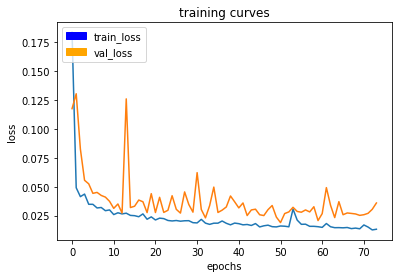

150/150 [==============================] - 97s - loss: 0.0132 - val_loss: 0.0359
Epoch 75/100
149/150 [============================>.] - ETA: 0s - loss: 0.0129

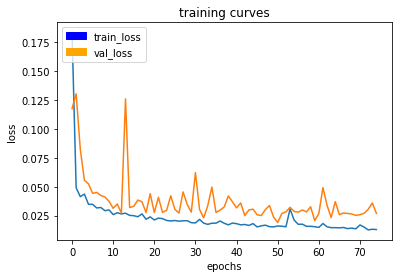

150/150 [==============================] - 97s - loss: 0.0129 - val_loss: 0.0270
Epoch 76/100
149/150 [============================>.] - ETA: 0s - loss: 0.0133

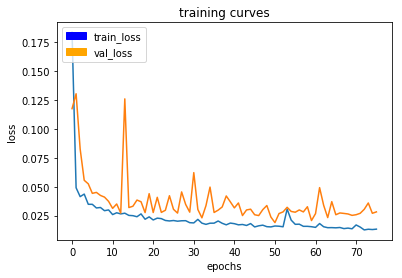

150/150 [==============================] - 97s - loss: 0.0133 - val_loss: 0.0282
Epoch 77/100
149/150 [============================>.] - ETA: 0s - loss: 0.0127

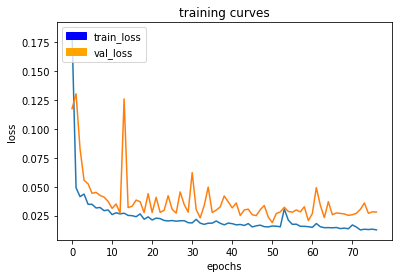

150/150 [==============================] - 97s - loss: 0.0126 - val_loss: 0.0281
Epoch 78/100
149/150 [============================>.] - ETA: 0s - loss: 0.0165

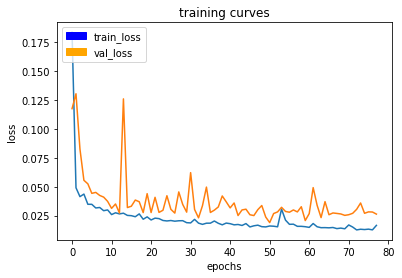

150/150 [==============================] - 96s - loss: 0.0165 - val_loss: 0.0263
Epoch 79/100
149/150 [============================>.] - ETA: 0s - loss: 0.0130

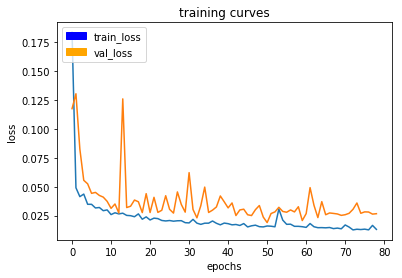

150/150 [==============================] - 97s - loss: 0.0130 - val_loss: 0.0266
Epoch 80/100
149/150 [============================>.] - ETA: 0s - loss: 0.0137

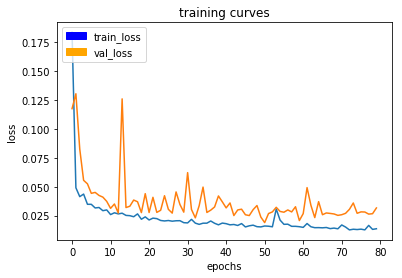

150/150 [==============================] - 97s - loss: 0.0137 - val_loss: 0.0316
Epoch 81/100
149/150 [============================>.] - ETA: 0s - loss: 0.0138

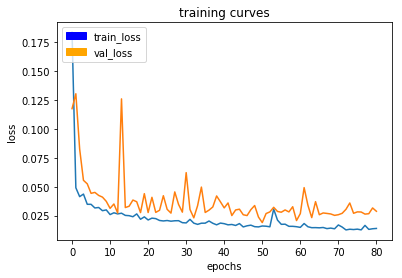

150/150 [==============================] - 97s - loss: 0.0139 - val_loss: 0.0287
Epoch 82/100
149/150 [============================>.] - ETA: 0s - loss: 0.0133

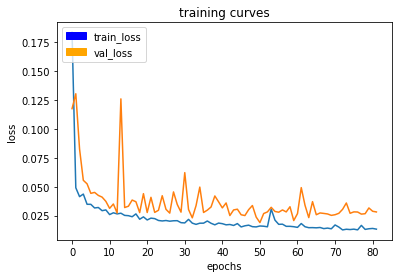

150/150 [==============================] - 97s - loss: 0.0133 - val_loss: 0.0281
Epoch 83/100
149/150 [============================>.] - ETA: 0s - loss: 0.0147

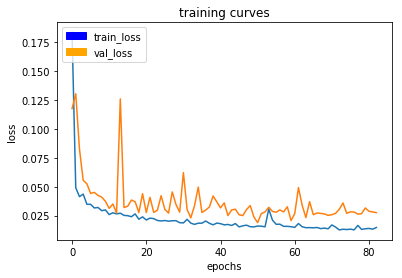

150/150 [==============================] - 97s - loss: 0.0147 - val_loss: 0.0275
Epoch 84/100
149/150 [============================>.] - ETA: 0s - loss: 0.0141

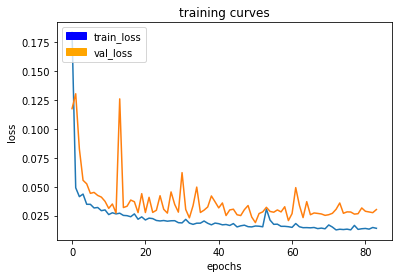

150/150 [==============================] - 97s - loss: 0.0141 - val_loss: 0.0302
Epoch 85/100
149/150 [============================>.] - ETA: 0s - loss: 0.0128

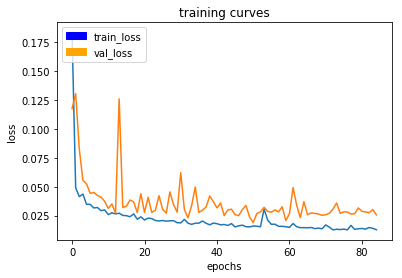

150/150 [==============================] - 97s - loss: 0.0128 - val_loss: 0.0256
Epoch 86/100
149/150 [============================>.] - ETA: 0s - loss: 0.0140

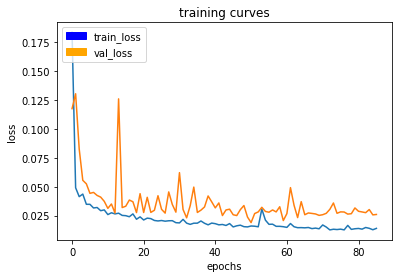

150/150 [==============================] - 97s - loss: 0.0140 - val_loss: 0.0260
Epoch 87/100
149/150 [============================>.] - ETA: 0s - loss: 0.0125

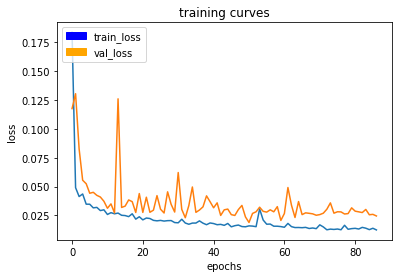

150/150 [==============================] - 97s - loss: 0.0125 - val_loss: 0.0246
Epoch 88/100
149/150 [============================>.] - ETA: 0s - loss: 0.0132

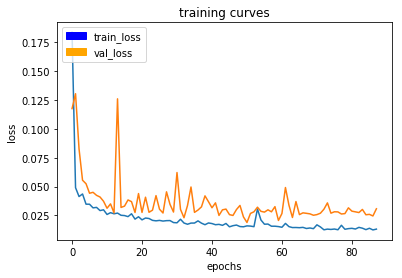

150/150 [==============================] - 97s - loss: 0.0132 - val_loss: 0.0308
Epoch 89/100
149/150 [============================>.] - ETA: 0s - loss: 0.0127

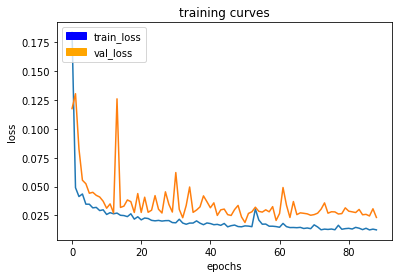

150/150 [==============================] - 97s - loss: 0.0127 - val_loss: 0.0233
Epoch 90/100
149/150 [============================>.] - ETA: 0s - loss: 0.0127

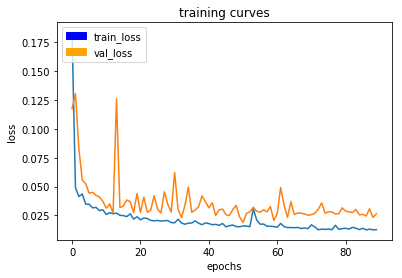

150/150 [==============================] - 96s - loss: 0.0127 - val_loss: 0.0265
Epoch 91/100
149/150 [============================>.] - ETA: 0s - loss: 0.0123

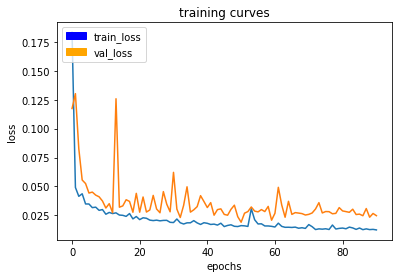

150/150 [==============================] - 97s - loss: 0.0123 - val_loss: 0.0246
Epoch 92/100
149/150 [============================>.] - ETA: 0s - loss: 0.0122

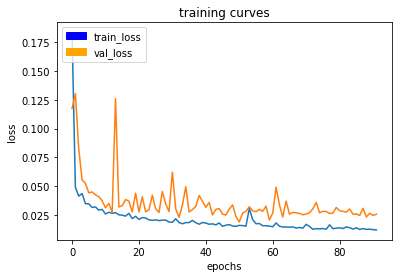

150/150 [==============================] - 97s - loss: 0.0121 - val_loss: 0.0257
Epoch 93/100
149/150 [============================>.] - ETA: 0s - loss: 0.0129

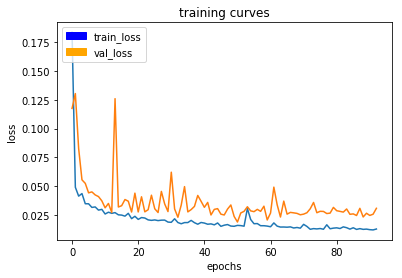

150/150 [==============================] - 96s - loss: 0.0129 - val_loss: 0.0308
Epoch 94/100
149/150 [============================>.] - ETA: 0s - loss: 0.0133

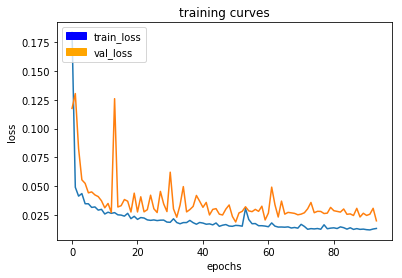

150/150 [==============================] - 97s - loss: 0.0133 - val_loss: 0.0200
Epoch 95/100
149/150 [============================>.] - ETA: 0s - loss: 0.0118

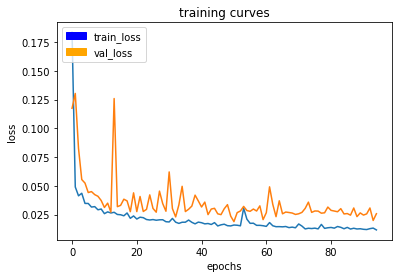

150/150 [==============================] - 97s - loss: 0.0118 - val_loss: 0.0258
Epoch 96/100
149/150 [============================>.] - ETA: 0s - loss: 0.0117

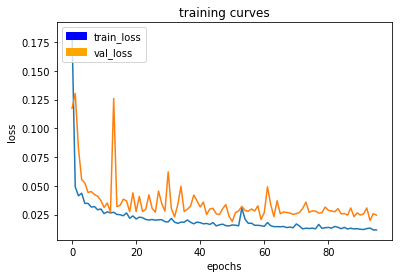

150/150 [==============================] - 97s - loss: 0.0117 - val_loss: 0.0246
Epoch 97/100
149/150 [============================>.] - ETA: 0s - loss: 0.0116

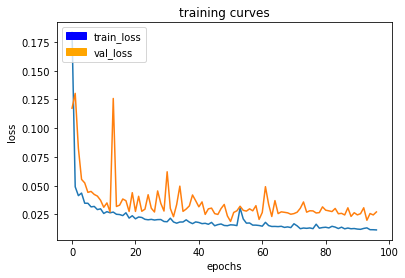

150/150 [==============================] - 96s - loss: 0.0116 - val_loss: 0.0272
Epoch 98/100
149/150 [============================>.] - ETA: 0s - loss: 0.0114

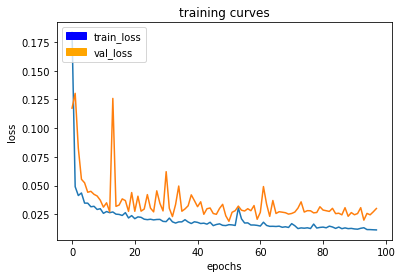

150/150 [==============================] - 98s - loss: 0.0114 - val_loss: 0.0301
Epoch 99/100
149/150 [============================>.] - ETA: 0s - loss: 0.0126

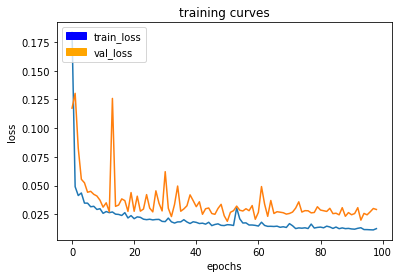

150/150 [==============================] - 97s - loss: 0.0126 - val_loss: 0.0292
Epoch 100/100
149/150 [============================>.] - ETA: 0s - loss: 0.0119

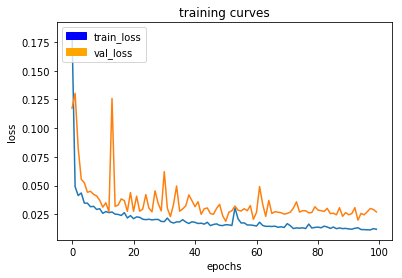

150/150 [==============================] - 97s - loss: 0.0120 - val_loss: 0.0271


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_2'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

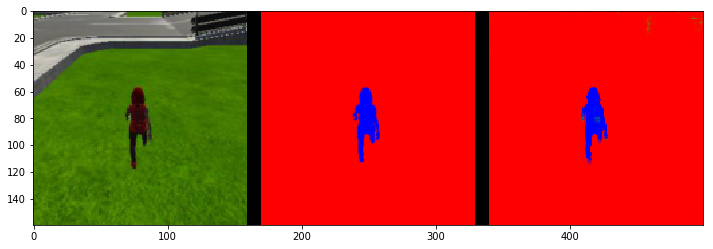

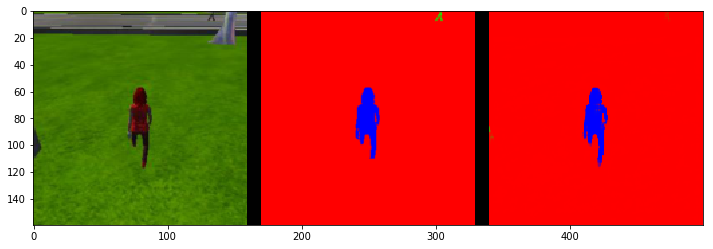

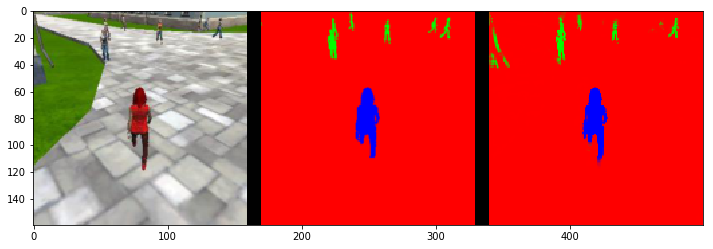

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

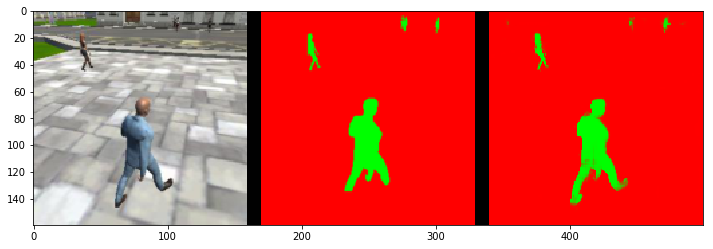

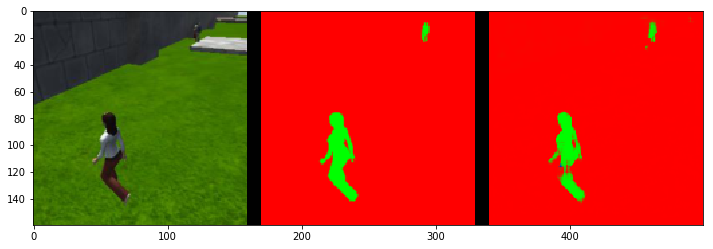

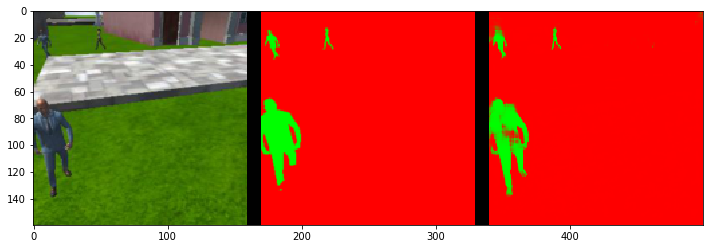

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

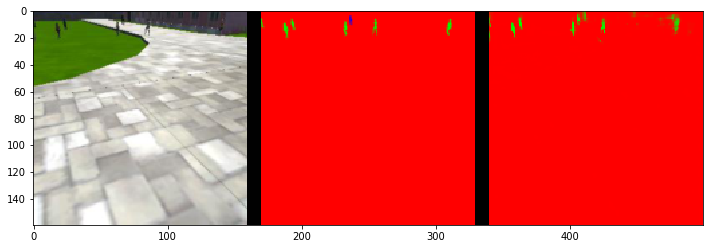

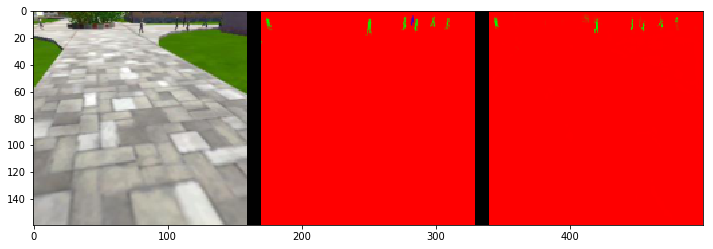

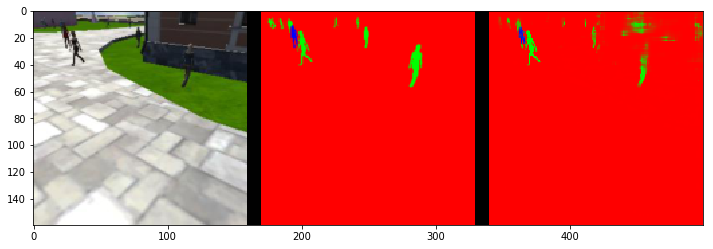

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9959740771895461
average intersection over union for other people is 0.3761483918881106
average intersection over union for the hero is 0.8798457806638624
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9887866425113977
average intersection over union for other people is 0.7781831677792369
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 34, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9962755547206522
average intersection over union for other people is 0.4556224562164779
average intersection over union for the hero is 0.23802667523948765
number true positives: 143, number false positives: 1, number false negatives: 158


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7794285714285715


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.558936227952


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.435650865672
